In [0]:
!unzip dataset.zip

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CartpoleNet(nn.Module):

  def __init__(self):
    super(CartpoleNet, self).__init__()
    # 6 output channels, 3x3 square convolution
    self.conv1 = nn.Conv3d(num_channels, 6, (1, 3, 3))
    self.fc1 = nn.Linear(6 * 2 * 63 * 63, 100)
    self.fc2 = nn.Linear(100, 50)
    self.fc3 = nn.Linear(50, 20)
    self.fc4 = nn.Linear(20, 4)
    self.JHist = []

  def forward(self, x):
    # Max pooling over a (2, 2, 2) window
    x = F.max_pool3d(F.relu(self.conv1(x)), 2)
    # print(x.shape)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

# images_per_set = 5
# num_samples = 10
# num_channels = 1

# net = CartpoleNet()
# print(net)
# input = torch.randn(num_samples, num_channels, images_per_set, 128, 128)
# out = net(input)
# print(out)

In [0]:
if __name__ == '__main__':
  from dataloader import CartpoleDataset
  import numpy as np
  torch.autograd.set_detect_anomaly(True)

  NUM_EPOCHS = 220
  # NUM_EPOCHS = 100
  LEARNING_RATE = 0.01
  E = 50  # epoch length
  n = 5  # images per set
  W = 128  # image width
  H = 128  # image height
  grayscale = True

  if not grayscale:
    num_channels = 3
  else:
    num_channels = 1

  net = CartpoleNet().float()
  full_dataset = CartpoleDataset('data.csv', './image_dataset/', n, grayscale=grayscale)

  for epoch in range(NUM_EPOCHS):
    # print("-"*50)
    # print("Epoch {}".format(epoch))
    # print("-"*50)
    e = epoch * 50  # current epoch beginning index
    current_epoch_imageset = torch.empty(E-n+1, num_channels, n, W, H)
    current_epoch_labelset = torch.empty(E-n+1, 4)
    for i in range(e+n-2, e+E-2):
      k = i-(e+n-2)
      current_epoch_imageset[k, :] = full_dataset[i][0]
      current_epoch_labelset[k] = torch.from_numpy(full_dataset[i][1][n-2])
    
    epoch_loss = 0
    # Mini-batches per epoch
    for i in range(E-n+1):
      criterion = nn.SmoothL1Loss()
      optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE)

      optimizer.zero_grad()

      pred_label = net(current_epoch_imageset[i].unsqueeze(0))

      loss = criterion(pred_label, current_epoch_labelset[i].unsqueeze(0))
      loss.backward()
      optimizer.step()

      # print("Loss(epoch={}, element={}): {}".format(epoch, i, loss.item()))
      epoch_loss += loss.item()
    epoch_loss /= (E-n)
    print("Epoch {} loss = {}".format(epoch, epoch_loss))
    net.JHist.append(epoch_loss)


[34.901276575815345, 5.914014792980419, 0.43581732399761675, 0.3086667510991295, 0.2863498172464056, 0.21931730265625649, 0.22459763133277497, 0.2409709567721519, 0.3219102050591674, 0.2607244806467659, 0.44243991679718925, 0.3331973157409165, 0.21035849182452593, 0.2941388480623977, 0.28397894859857237, 0.2046765749873076, 0.3562727307208762, 0.29686931137694045, 0.3017778316266938, 0.25785676318143186, 0.2779346131396273, 0.300636515868569, 0.24204634194158844, 0.2688310884773576, 0.23372190062913836, 0.21421799063941258, 0.28866381779338957, 0.21012395239667966, 0.26294442180385685, 0.2671163580490328, 0.2623580598126864, 0.2294214283568888, 0.2962784763406186, 0.3469131857062975, 0.2669035778549086, 0.3069854085052308, 0.22641604556766753, 0.27989298701997745, 0.2137064847794439, 0.35290347455949006, 0.2462810837650775, 0.2256767470544825, 0.276281198126445, 0.1839093507396885, 0.22931486246509142, 0.35039095254970665, 0.2896747006523785, 0.18949641725436475, 0.2617181882249295, 0.

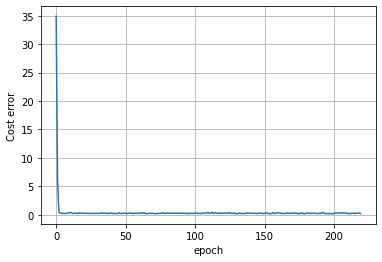

In [46]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(0, NUM_EPOCHS-1, NUM_EPOCHS), net.JHist)
print(net.JHist)
plt.ylabel("Cost error")
plt.xlabel("epoch")
plt.grid()
plt.show()

In [0]:
PATH = './CartpoleNet_nishant.pth'
torch.save(net.state_dict(), PATH)